

















# 介紹 - 題目： 如何用 DTW 在市場趨勢下時逆向獲利
## 一、動機, 原理

## 二、DTW

## 三、實作 + yfinance
### 1. heatmap、吐值、回朔圖
```
<相似度> 假設 一天交易時數 6小時

一年(2 day) 5*52/2=130 

半年(1 day) 22*6=132

三個月(3hr ) 2*22*3=132

一個月(1hr) 6*22=132

一週（15min)  4*6*5=120
```
### 2. 英雄股
```
<英雄股> 時間軸：(要有 D-1, D-0的概念 = 要分清 當天與昨天）

1天 3分鐘   （120） D-1

3天 10分鐘 （108）

1週 15分鐘 （120）
```

## 四、待定 (telegram)


In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import requests
import io
import zipfile
import math
import time
import sys
import datetime
import numpy as np
import pandas as pd
from numpy_ext import rolling_apply
import re
from dtaidistance import dtw
from matplotlib.axis import Tick
from dtaidistance import dtw_visualisation as dtwvis
from matplotlib import cm 
from matplotlib.colors import ListedColormap

import matplotlib.patches as mpatches
    
import matplotlib.font_manager as fm
korea_font = fm.FontProperties(fname='./malgun.ttf', size= 15)


c:\Users\julia\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# [韓文法](https://www.kaggle.com/general/232729) + [字體](https://blog.csdn.net/mighty13/article/details/116243372)
### 1. import matplotlib.font_manager as fm; korea_font = fm.FontProperties(fname='./malgun.ttf')
### 2. fontproperties=korea_font

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# plt.rcParams['font.family'] = 'sans-serif'
# # rcParams['font.sans-serif'] = ['Microsoft YaHei']
# plt.rcParams['font.sans-serif']=['BaTangChe'] # 用来正常显示韩语标签
# plt.rcParams['axes.unicode_minus'] = False


# 必要函數 - 歸一化

In [3]:
def minmax(df):
    df_minmax = (df - df.min())/(df.max() - df.min())
    return df_minmax

# DTW

In [4]:
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
d = dtw.distance_fast(s1, s2)
d

1.4142135623730951

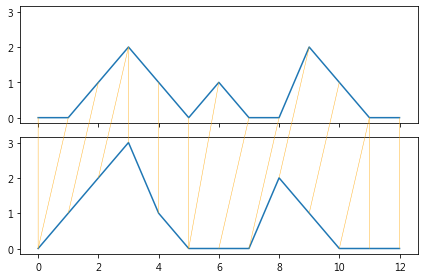

In [5]:
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
plt.show()

In [6]:
def plot_plot(wanted_string, period='1mo', interval='1d', annot= True, xrotation = 0, yrotation = 0, labels = None):
    data = yf.download(  
        tickers = wanted_string,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = interval,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )

    df = pd.DataFrame()
    data_max = []
    data_min = []
    data_last = []
    for i in wanted_string.split(" "):
        if len(minmax(data[(f'{i}',   'Close')].dropna()).values) > 0:
            data[(f'{i}',   'Close')] = data[(f'{i}',   'Close')].ffill()
            df[f'{i}'] = minmax(data[(f'{i}',   'Close')])
            data_max.append(data[(f'{i}',   'Close')].max())
            data_min.append(data[(f'{i}',   'Close')].min())
            data_last.append(data.iloc[-1][(f'{i}',   'Close')])

    df = df.ffill()

    plt.figure(figsize= (20, 10), facecolor='white') 
    ax = plt.gca()

    data_max_np = np.array(data_max)
    data_min_np = np.array(data_min)
    data_last_np = np.array(data_last)

    data_H = ((data_last_np - data_max_np)/data_max_np)*100
    data_L = ((data_last_np - data_min_np)/data_min_np)*100

    
    # 有label才有
    new_labels = []
    for i, origin in enumerate(labels):
        new_labels.append(origin + " H:{}%, L:+{}%".format(round(data_H[i], 2), round(data_L[i], 2)))

    if not new_labels is None:
        df.columns = new_labels
        df.plot(ax= ax)
    else:
        df.plot(ax= ax)
    ax.yaxis.tick_right() 
    plt.title('Similarity - CORR', fontsize = 20)
    plt.xlabel('Powered by Team SuperNormal', horizontalalignment='right', x=1.05, fontsize = 15)
    plt.legend(loc = 2, fontsize= 15, prop = korea_font) # , prop = korea_font
    plt.show()

[*********************100%***********************]  6 of 6 completed


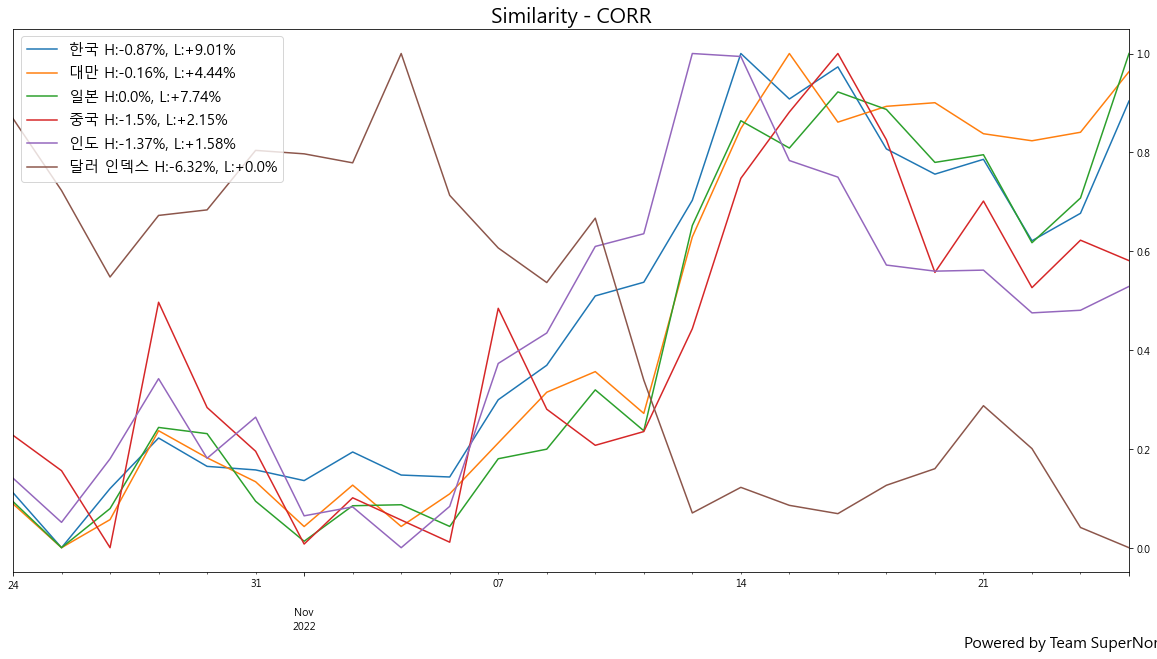

In [7]:
wanted = "KRWUSD=X TWDUSD=X JPYUSD=X CNYUSD=X INRUSD=X DX-Y.NYB"
plot_plot(wanted, period='1mo', interval='1d', xrotation= 90, yrotation=0, labels=["한국", "대만", "일본", "중국", "인도", "달러 인덱스"])

[*********************100%***********************]  5 of 5 completed


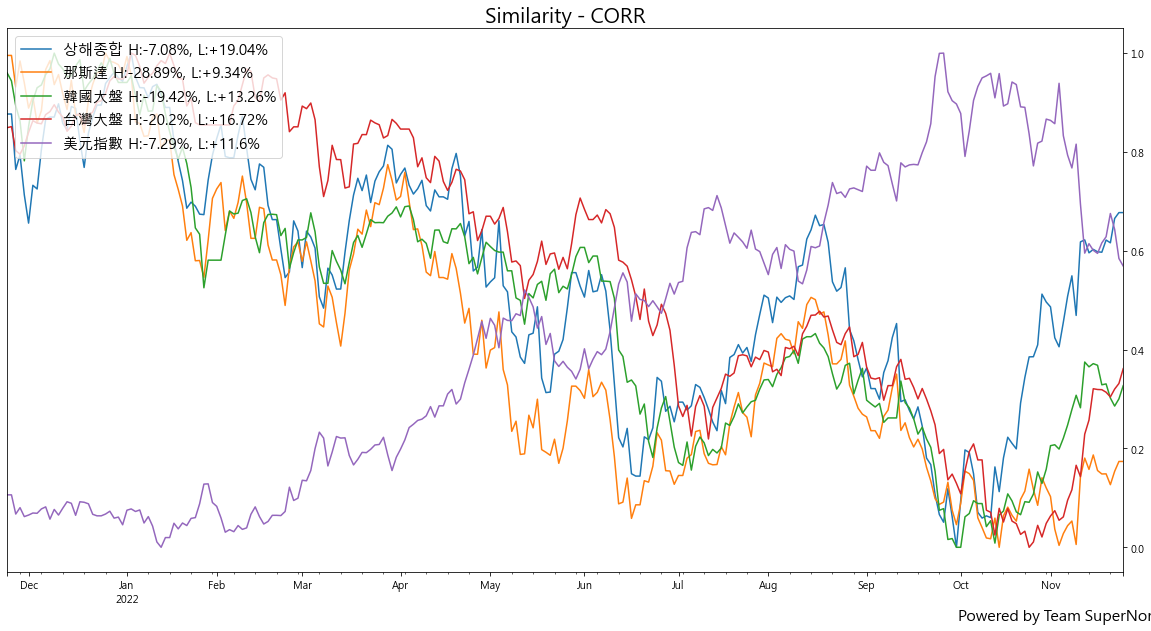

In [8]:
wanted = "^DJI ^IXIC ^KS11 ^TWII DX-Y.NYB"
plot_plot(wanted, period='1y', interval='1d', xrotation= 90, yrotation=0, labels=["상해종합", "那斯達", "韓國大盤", "台灣大盤", "美元指數"])

### heatmap - 大資金的盤，趨勢線狠準

In [9]:
def heatmap_hero(wanted_string, period='1mo', interval='1d', annot= True, xrotation = 0, yrotation = 0, xlabel=None):
    data = yf.download(  
        tickers = wanted_string,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = interval,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )
    series = []
    save_stock = []
    for i in wanted_string.split(" "):
        if len(minmax(data[(f'{i}',   'Close')].dropna()).values) > 0:
            series.append(minmax(data[(f'{i}',   'Close')].dropna()).values)
            save_stock.append(i)

    if not xlabel is None:
        xtickk = xlabel.split(" ")
    else:
        xtickk = save_stock

    ds = dtw.distance_matrix_fast(series)
    ds2 = np.flip(ds, 0)

    plt.figure(figsize= (20, 20), facecolor='white')
    ax = plt.gca()
    sns.heatmap(ds2, annot= annot, square=True, fmt='.3f', annot_kws={'size': 15}, cmap ='RdBu', cbar_kws={"shrink": 0.824})
    ax.set_yticklabels(xtickk[::-1], rotation = yrotation, fontsize= 13, fontproperties=korea_font)
    ax.set_xticklabels(xtickk,  rotation = xrotation, fontsize= 13, fontproperties=korea_font)
    plt.title('Similarity - DTW', fontsize = 20)
    plt.xlabel('Powered by Team SuperNormal', horizontalalignment='right', x=1.15, fontsize = 15)
    plt.show()

# 用圖中圖，加一條colorbar，再改yticklabels，這樣方便點。

In [10]:
def heatmap_corr(wanted_string, period='1mo', interval='1d', annot= True, xrotation = 0, yrotation = 0, xlabel=None):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.cm
    cmap = matplotlib.cm.get_cmap('RdBu')
    data = yf.download(  
        tickers = wanted_string,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = interval,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )

    df = pd.DataFrame()
    for i in wanted_string.split(" "):
        if len(minmax(data[(f'{i}',   'Close')].dropna()).values) > 0:
            df[f'{i}'] = minmax(data[(f'{i}',   'Close')]).values
            

    corrs = df.ffill().corr().values
    ds2 = np.flip(corrs, 0)

    
    if not xlabel is None:
        xtickk = xlabel.split(" ")
    else:
        xtickk = df.columns

    fig= plt.figure(figsize= (20, 20), facecolor='white')
    ax = plt.gca()
    tickss = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
    sns.heatmap(ds2, annot= annot, square=True, fmt='.3f', annot_kws={'size': 15}, cmap ='RdBu_r', cbar=False, cbar_kws={"shrink": 0.824, 'ticks':tickss}, ax=ax)
    # ax.collections[0].cmap(plt.get_cmap('RdBu'))
    # ax.collections[0].colorbar.set_ticklabels(tickss[::-1])
    ax.set_yticklabels(xtickk[::-1], rotation = yrotation, fontsize = 13, fontproperties=korea_font)
    ax.set_xticklabels(xtickk,  rotation = xrotation,fontsize = 13, fontproperties=korea_font)
    plt.title('Similarity - CORR', fontsize = 20)
    plt.xlabel('Powered by Team SuperNormal', horizontalalignment='right', x=1.1, fontsize = 15)

    # fig = plt.figure(figsize=(8, 2))
    ax1 = fig.add_axes([0.92, 0.124, 0.035, 0.751])
    
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap = cmap, norm=norm, orientation='vertical')
    ax1.set_yticks(tickss)
    ax1.set_yticklabels(tickss[::-1])
    plt.show()

[*********************100%***********************]  16 of 16 completed


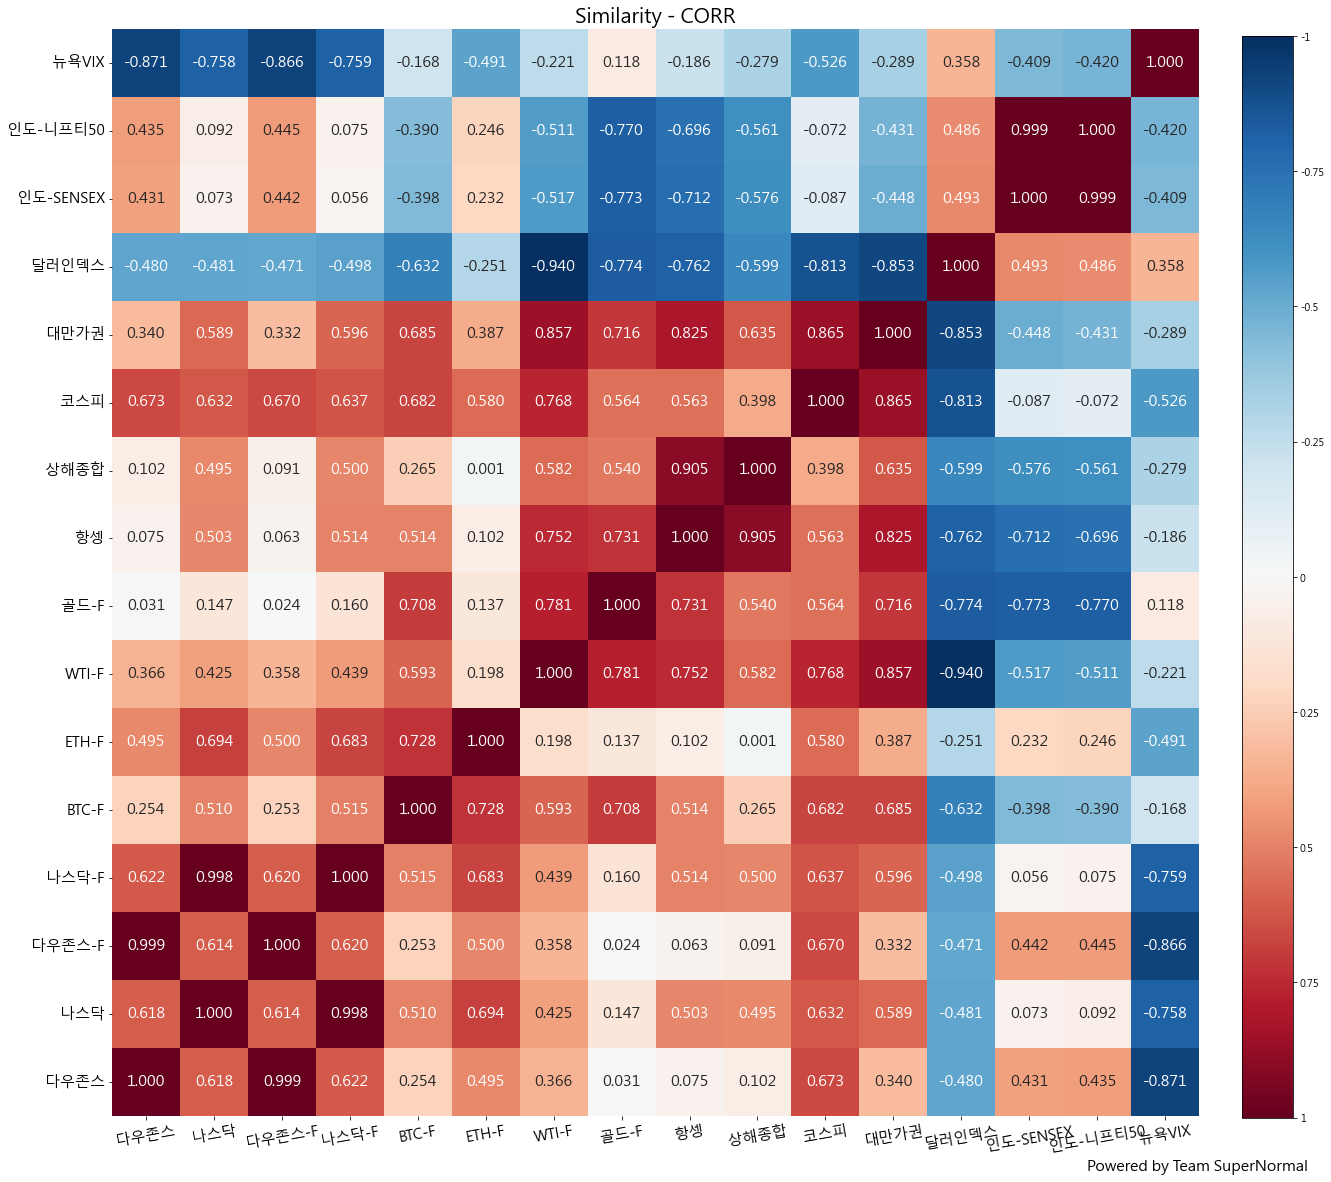

In [11]:
wanted = "^DJI ^IXIC YM=F NQ=F BTC=F ETH=F GC=F CL=F ^HSI 000001.SS ^KS11 ^TWII DX-Y.NYB ^BSESN ^NSEI ^VIX"
xlabel = "다우존스 나스닥 다우존스-F 나스닥-F BTC-F ETH-F WTI-F 골드-F 항셍 상해종합 코스피 대만가권 달러인덱스 인도-SENSEX 인도-니프티50 뉴욕VIX"
heatmap_corr(wanted, period='6mo', interval='1d', xrotation= 10, yrotation=0, xlabel=xlabel)

[*********************100%***********************]  13 of 13 completed


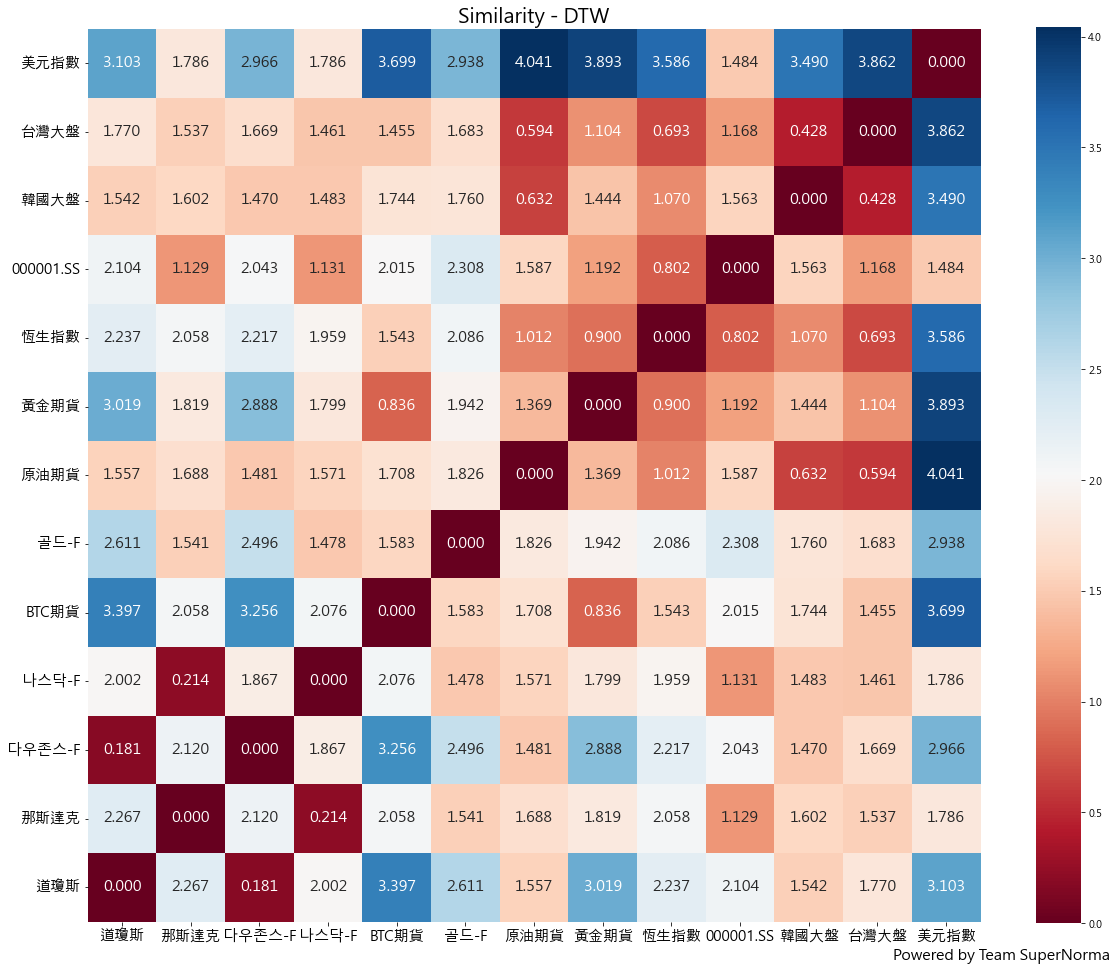

In [12]:
wanted = "^DJI ^IXIC YM=F NQ=F BTC=F ETH=F GC=F CL=F ^HSI 000001.SS ^KS11 ^TWII DX-Y.NYB"
xlabel = "道瓊斯 那斯達克 다우존스-F 나스닥-F BTC期貨 골드-F 原油期貨 黃金期貨 恆生指數 000001.SS 韓國大盤 台灣大盤 美元指數"
heatmap_hero(wanted, period='6mo', interval='1d', xrotation= 0, yrotation=0, xlabel=xlabel)

### 各時間線

In [13]:
def multi_time(string):

    # 時間段
    today = pd.to_datetime('today').replace(microsecond= 0)
    time1w = datetime.timedelta(days=7)
    time1mo = datetime.timedelta(days=30)
    time3mo = datetime.timedelta(days=90)
    time6mo = datetime.timedelta(days=180)
    time12mo = datetime.timedelta(days=365)
    
    # Stock process
    want_list = string.split('&')
    want_cup_list = [x.strip() for x in want_list]
    want_list = np.array([x.split("-") for x in want_cup_list])
    want_list = list(set(want_list.ravel()))
    stock_string = " ".join(want_list)
    


    # get data
    data7 = yf.download(tickers = stock_string, period = '7d', interval = "15m", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data30 = yf.download(tickers = stock_string, period = '1mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data90 = yf.download(tickers = stock_string, period = '3mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data180 = yf.download(tickers = stock_string, period = '6mo', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data365 = yf.download(tickers = stock_string, period = '1y', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    
    # time list
    time_delt = [time1w, time1mo, time3mo, time6mo, time12mo]

    # built first dataframe
    promote = want_cup_list[0].replace("^", "")
    lists = [[promote], ['DTW']] #'Time Period', 
    index = pd.MultiIndex.from_product(lists)
    df = pd.DataFrame(columns= index)

    # 計算
    for groups in want_cup_list:
        stock = groups.split("-")
        promote = groups.replace("^", "")

        tt_list = []
        distance_list = []
        corr = []
        for tt in time_delt:

            if tt.days == 7:
                ss = data7.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values

                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
         
            elif tt.days == 30:
                ss = data30.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.resample('1h', closed='right', label = 'left').last().dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
         
            elif tt.days == 90:
                ss = data90.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.resample('3h', closed='right', label = 'right').last().dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
        
            elif tt.days == 180:
                ss = data180.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
        
            elif tt.days == 365:
                ss = data365.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.dropna().resample('2D', closed='right', label = 'right').last().dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
              

        df.loc[:, (promote, 'DTW')] = distance_list
        df.loc[:, (promote, 'Pearson')] = corr
        
    # set index 
    df['Period'] = ['7', '30', '90', '180', '365']
    df = df.set_index('Period')
   
    return df

In [14]:
wanted = "^DJI-^IXIC & ^KS11-000001.SS & ^TWII-^KS11 & BTC=F-ETH=F"
a = multi_time(wanted)
a

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


DJI-IXIC         KS11-000001.SS         TWII-KS11         BTC=F-ETH=F  \
            DTW Pearson            DTW Pearson       DTW Pearson         DTW   
Period                                                                         
7         2.263   0.202          0.879   0.773     2.481   0.035       1.371   
30        1.685   0.542          1.164   0.822     0.784   0.873       1.175   
90        3.128   0.351          1.621   0.614     0.702   0.750       1.578   
180       2.267   0.624          1.511   0.349     0.413   0.848       1.583   
365       1.605   0.895          0.798   0.723     0.430   0.928       0.572   

                
       Pearson  
Period          
7        0.958  
30       0.981  
90       0.840  
180      0.713  
365      0.977

### 回朔畫圖
1. 一年以下以frame大小做 rolling
2. 一年以上以52周(一年) 做rolling

In [24]:
def similary(stock_wanted:str, labels = None):
    stock = [x.strip() for x in stock_wanted.split("$")]
    time_string = re.search(r'(\d+)(\w+)', stock[1])


    if stock[1] == '7d':
        data365_tem = yf.download(tickers = stock[0], period = '14d', interval = "15m", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.dropna()
        day = 7
    elif stock[1] == '1mo':
        data365_tem = yf.download(tickers = stock[0], period = '2mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.resample('1h', closed='right', label = 'left').last().dropna()
        day = 30
    elif stock[1] == '3mo':
        data365_tem= yf.download(tickers = stock[0], period = '6mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.resample('3h', closed='right', label = 'right').last().dropna()
        day = 90
    elif stock[1] == '6mo':
        data365_tem = yf.download(tickers = stock[0], period = '1y', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.dropna()
        day = 180
    elif stock[1] == '1y':
        data365_tem = yf.download(tickers = stock[0], period = '2y', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None).dropna()
        data365 = data365_tem.resample('2D', closed='right', label = 'right').last().dropna()
        day = 365
    elif time_string.group(2) == 'y':
        num = int(time_string.group(1)) + 1
        period = str(num) + time_string.group(2)
        data365_tem = yf.download(tickers = stock[0], period = period, interval = "1wk", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.dropna()
        day = 365
    else:
        print("Type Error")
        return 0


    def masscenter(s1, s2):
        ss1 = minmax(s1)
        ss2 = minmax(s2)
        return dtw.distance(ss1, ss2, use_pruning=True)

    def corrs(s1, s2):
        ss1 = minmax(s1)
        ss2 = minmax(s2)
        return np.corrcoef(ss1, ss2)[0, 1]

    # string
    ff = re.search(r'(\S+)\s+(\S+)', stock[0])

    dfs = data365.loc[:, [(ff.group(1),   'Close'), (ff.group(2),   'Close')]]
    
    if time_string.group(2) != 'y' or stock[1] == '1y':
        window = int(len(dfs)/2)
        dfs['dtw'] = rolling_apply(masscenter, window, dfs[(ff.group(1),   'Close')].values.astype(np.double), dfs[(ff.group(2),   'Close')].values.astype(np.double))
        dfs['corr'] = rolling_apply(corrs, window, dfs[(ff.group(1),   'Close')].values.astype(np.double), dfs[(ff.group(2),   'Close')].values.astype(np.double))

    elif time_string.group(2) == 'y':      
        window = 52
        dfs['dtw'] = rolling_apply(masscenter, window, dfs[(ff.group(1),   'Close')].values.astype(np.double), dfs[(ff.group(2),   'Close')].values.astype(np.double))
        dfs['corr'] = rolling_apply(corrs, window, dfs[(ff.group(1),   'Close')].values.astype(np.double), dfs[(ff.group(2),   'Close')].values.astype(np.double))
    
    else:
        print("Type Error")
        return 0

    data_his = dfs.dropna()
    data1_min, data1_max = data_his[(ff.group(1), 'Close')].min(), data_his[(ff.group(1), 'Close')].max()
    data2_min, data2_max = data_his[(ff.group(2), 'Close')].min(), data_his[(ff.group(2), 'Close')].max()
    data1_last, data2_last = data_his.iloc[-1][(ff.group(1), 'Close')], data_his.iloc[-1][(ff.group(2), 'Close')]
    # print(data1_max, data1_min, data2_max, data2_min, data1_last, data2_last)

    data1_H = (data1_max - data1_last)/data1_max
    data1_L = (data1_last - data1_min)/data1_min
    data2_H = (data2_max - data2_last)/data2_max
    data2_L = (data2_last - data2_min)/data2_min
    # print(data1_H, data1_L, data2_H, data2_L)

    data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]] = minmax(data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]])
    
    if not labels is None:
        label1 = labels[0]
        label2 = labels[1]
    else:
        label1 = ff.group(1).replace("^", "")
        label2 = ff.group(2).replace("^", "")

    fig = plt.figure(figsize=(12, 9), facecolor='white')
    rect = fig.patch
    rect.set_facecolor('white')
    grid = plt.GridSpec(4, 3, figure= fig, hspace= 0)
    plt.subplot(grid[0:3, 0:3])
    plt.title(f'{stock[1]} Similarity History Plot', fontsize = 15)
    plt.plot(data_his.index, data_his[(ff.group(1), 'Close')], label = label1 + " (H:-{}%, L:+{}%)".format(round(data1_H*100, 2), round(data1_L*100, 2)))
    plt.plot(data_his.index, data_his[(ff.group(2), 'Close')], label = label2 + " (H:-{}%, L:+{}%)".format(round(data2_H*100, 2), round(data2_L*100, 2)))
    korea_font = fm.FontProperties(fname='./malgun.ttf', size= 13)
    plt.legend(fontsize = 13, prop =  korea_font)
    ax = plt.gca()
    ax.xaxis.set_ticks([])
    
    # plt.xticks(rotation= -10)
    plt.subplot(grid[3:4, 0:3])
    plt.annotate('Powered by Team SuperNormal', (0.5, 0.5), (0.57, 0.045), xycoords= 'figure fraction',fontsize = 15)
    ax1 = plt.gca()
    ax.yaxis.tick_right() 
    ax2 = ax1.twinx()
    
    ax1.plot(data_his.index, data_his['dtw'], c ='r')
    ax2.plot(data_his.index, data_his['corr'], c ='b')
    # ax1.legend(fontsize = 15)
    # ax2.legend(fontsize = 15)

    red_patch = mpatches.Patch(color='red', label = 'Alpha-L ({}, {})'.format(day, round(data_his['dtw'][-1], 2)))
    blue_patch = mpatches.Patch(color='blue', label = 'Beta-R ({}, {})'.format(day, round(data_his['corr'][-1], 2)))

    plt.legend(handles=[red_patch, blue_patch], loc= 2)
    
    plt.show()

[*********************100%***********************]  2 of 2 completed


C:\Users\julia\AppData\Local\Temp\ipykernel_20136\3195845883.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]] = minmax(data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]])


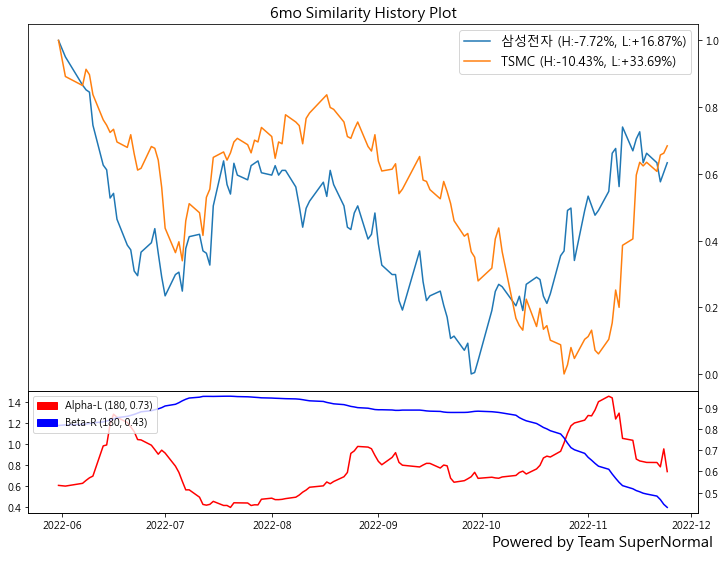

In [16]:
similary('005930.KS 2330.TW $ 6mo', ['삼성전자', 'TSMC'])

[*********************100%***********************]  2 of 2 completed


C:\Users\julia\AppData\Local\Temp\ipykernel_20136\3195845883.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]] = minmax(data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]])


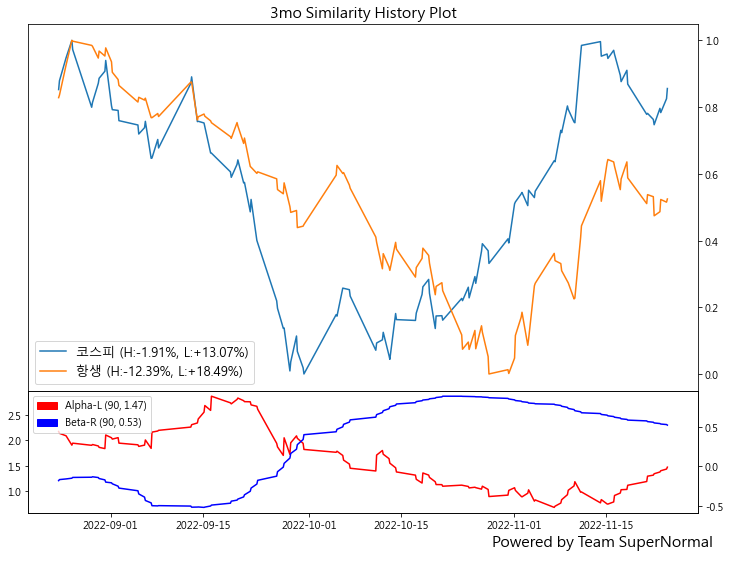

In [17]:
similary('^KS11 ^HSI $ 3mo', ['코스피', '항생'])

[*********************100%***********************]  2 of 2 completed


C:\Users\julia\AppData\Local\Temp\ipykernel_20136\2362271693.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]] = minmax(data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]])


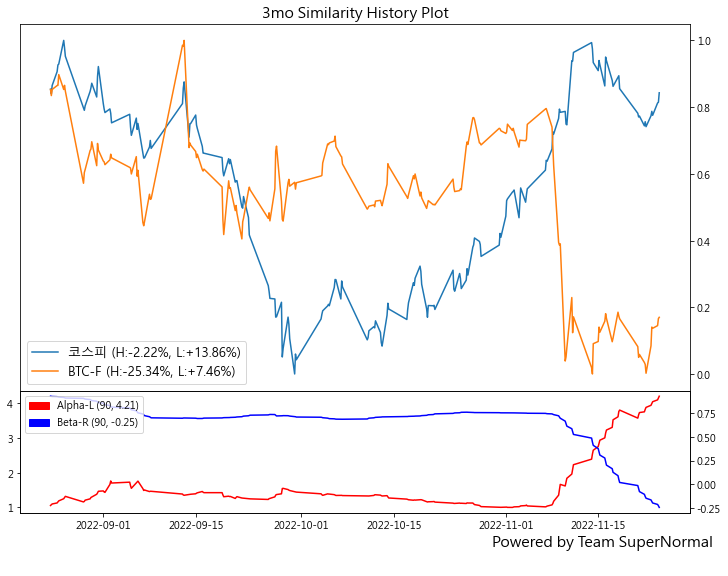

In [25]:
similary('^KS11 BTC=F $ 3mo $ corr', ['코스피', 'BTC-F'])

# 英雄股

In [60]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
user_agent = UserAgent()

In [61]:
first = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=0'
first1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=25'
second = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=50'
second1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=75'
third = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=100'
third1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=125'
fourth = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=150'
fourth1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=175'
url_list = [first, second, third, fourth, first1, second1, third1, fourth1]
yahoo_all = []
for url in url_list:
    page = requests.get(url, headers= { 'user-agent': user_agent.random})
    soup = BeautifulSoup(page.text, 'lxml')
    yahoo = soup.find('table', class_ = 'W(100%)').find_all('tr', class_ = 'simpTblRow Bgc($hoverBgColor):h BdB Bdbc($seperatorColor) Bdbc($tableBorderBlue):h H(32px) Bgc($lv2BgColor)')
    for stock in yahoo:
        yahoo_all.append(stock.find('a', {"data-test":"quoteLink"}).text)

datas = " ".join(list(set(yahoo_all)))
datas = '^IXIC ' + datas

AttributeError: 'NoneType' object has no attribute 'find_all'

In [ ]:
stock_list = ['RTX', 'JNJ', 'PEP', 'NVDA', 'BACHF', 'CICHY', 'NVSEF', 'TD', 'BML-PG', 'ORCL', 'ABT', 'SHEL', 'NKE', 'WFC-PL', 'BUD', 'MPNGY', 'MA', 'SNEJF', 'CVS', 'CIHKY', 'BML-PJ', 'PFE', 'TTFNF', 'NEE', 'C-PJ', 'STOHF', 'PYPL', 'ABBV', 'WFC-PQ', 'DHR', 'CILJF', 'AMD', 'TSM', 'RYDAF', 'HDB', 'PTR', 'BMY', 'ACN', 'AAPL', 'PROSY', 'RHHBY', 'RLLCF', 'VZ', 'NSRGF', 'RHHVF', 'T', 'JPM', 'NONOF', 'TSLA', 'AMGN', 'BABAF', 'RY', 'AMT', 'BAC-PL', 'SPGI', 'AMZN', 'AAGIY', 'AAIGF', 'NSRGY', 'DGEAF', 'BABA', 'HESAY', 'DIS', 'BYDDF', 'AVGO', 'CVX', 'HBCYF', 'TMUS', 'CMWAY', 'TMO', 'SNY', 'BP', 'NVS', 'TOYOF', 'GS', 'ASML', 'BAC', 'CICHF', 'MDT', 'TXN', 'IBM', 'LIN', 'WFC-PY', 'HESAF', 'UNP', 'ADP', 'AXP', 'COP', 'ACGBY', 'BAC-PB', 'BYDDY', 'ADBE', 'WFC', 'INTC', 'GOOG', 'QCOM', 'RHHBF', 'LLY', 'MRK', 'MS', 'HSBC', 'TTE', 'ELV', 'EQNR', 'UL', 'BLK', 'RTNTF', 'BUDFF', 'LOW', 'SAPGF', 'PIAIF', 'UPS', 'DE', 'WFC-PR', 'BRK-B', 'SAP', 'SONY', 'LVMHF', 'LMT', 'BHP', 'COST', 'CAT', 'CBAUF', 'PBR', 'BML-PH', 'INTU', 'NFLX', 'BAC-PE', 'BHPLF', 'DEO', 'MCD', 'BAC-PK', 'BML-PL', 'HON', 'IDCBY', 'LRLCF', 'WFC-PC', 'LRLCY', 'KO', 'ASMLF', 'CRM', 'HD', 'PNGAY', 'BX', 'AZN', 'CSCO', 'UNLYF', 'C', 'TM', 'BACHY', 'NVO', 'LVMUY', 'CMCSA', 'PM', 'JDCMF', 'SCHW', 'XOM']
datas = " ".join(stock_list)
datas

'RTX JNJ PEP NVDA BACHF CICHY NVSEF TD BML-PG ORCL ABT SHEL NKE WFC-PL BUD MPNGY MA SNEJF CVS CIHKY BML-PJ PFE TTFNF NEE C-PJ STOHF PYPL ABBV WFC-PQ DHR CILJF AMD TSM RYDAF HDB PTR BMY ACN AAPL PROSY RHHBY RLLCF VZ NSRGF RHHVF T JPM NONOF TSLA AMGN BABAF RY AMT BAC-PL SPGI AMZN AAGIY AAIGF NSRGY DGEAF BABA HESAY DIS BYDDF AVGO CVX HBCYF TMUS CMWAY TMO SNY BP NVS TOYOF GS ASML BAC CICHF MDT TXN IBM LIN WFC-PY HESAF UNP ADP AXP COP ACGBY BAC-PB BYDDY ADBE WFC INTC GOOG QCOM RHHBF LLY MRK MS HSBC TTE ELV EQNR UL BLK RTNTF BUDFF LOW SAPGF PIAIF UPS DE WFC-PR BRK-B SAP SONY LVMHF LMT BHP COST CAT CBAUF PBR BML-PH INTU NFLX BAC-PE BHPLF DEO MCD BAC-PK BML-PL HON IDCBY LRLCF WFC-PC LRLCY KO ASMLF CRM HD PNGAY BX AZN CSCO UNLYF C TM BACHY NVO LVMUY CMCSA PM JDCMF SCHW XOM'

In [ ]:
def heatmap_hero(wanted_string, period='1mo', interval='1d', annot= True, xrotation = 0, yrotation = 0, figsize= 20):
    data = yf.download(  
        tickers = wanted_string,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = interval,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )
    series = []
    save_stock = []
    for i in wanted_string.split(" "):
        if len(data[(f'{i}',   'Close')].dropna()) > 0:
            series.append(minmax(data[(f'{i}',   'Close')].dropna()).values)
            save_stock.append(i)
            
    ds = dtw.distance_matrix_fast(series)
    ds2 = np.flip(ds, 0)
    plt.figure(figsize= (figsize, figsize), facecolor='white')
    ax = plt.gca()
    sns.heatmap(ds2, annot= annot, square=True, fmt='.3f', annot_kws={'size': 15}, cmap ='RdBu', cbar_kws={"shrink": 0.824})
    ax.set_yticks(np.arange(0, len(save_stock), 1), np.array(save_stock)[::-1], rotation = yrotation)
    ax.set_xticks(np.arange(0, len(save_stock), 1), np.array(save_stock),  rotation = xrotation)
    plt.title('Similarity - DTW', fontsize = 20)
    plt.xlabel('Powered by Team SuperNormal', horizontalalignment='right', x=1.15, fontsize = 15)
    plt.show()


    # return value
    a = np.array(save_stock)
    invert_a = np.array(save_stock)[::-1]
    df = pd.DataFrame()
    for num, i in enumerate(ds2):
        df[invert_a[num]] = i

    df.index = a
    df = df.T
    df_result = df.sort_values(by=a[0]).sort_values(by=a[0], axis= 1)
    return df_result

In [ ]:
s = heatmap_hero(datas, period='1d', interval='2m', annot= False, xrotation= 90, figsize= 40)

NameError: name 'datas' is not defined

In [ ]:
s.to_excel('IXIC_1d_2m.xlsx')